In [1]:
import numpy
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.optimize
%matplotlib inline
from numpy import asarray

In [2]:
def uniquify(seq, idfun=None): 
   # order preserving
    if idfun is None:
        def idfun(x): return x
    seen = {}
    result = []
    for item in seq:
        marker = idfun(item)
        # in old Python versions:
        # if seen.has_key(marker)
        # but in new ones:
        if marker in seen: continue
        seen[marker] = 1
        result.append(item)
    return result

# Data

In [3]:
# t1 is for Cx and t2 is for rCO2 (both are in hours)
t1 = [1.5, 2.5, 3.5, 4.5, 5.5] 
t2 = [1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25] 

In [4]:
# A4
Cx_4_A = [0.9445,1.2946,1.6352,2.0085,2.4633] # g/L
rco2_4_A = [2.8,3.7,3.9,4.7,5.8,7.1,7.5,10,10.4] # ml/min

In [5]:
# B4
Cx_4_B = [0.925408 ,1.392516, 1.7841192, 1.9615644, 2.3082964] # g/L
rco2_4_B = [4.2, 3.213, 3.61, 4.65, 5.48, 6.6, 8, 9, 9.65] # ml/min

In [6]:
# C4
Cx_4_C = [0.9873568, 1.3231696, 1.6515452, 1.994198, 2.5163356] # g/L
rco2_4_C = [1.75, 2.275, 3.04286, 3.833, 5.2, 6.5, 6.7, 8.335, 9.8] # ml/min

In [7]:
Cx_4_avg=[]
for index,value in enumerate(Cx_4_A):
    sum_avg=Cx_4_A[index]+Cx_4_B[index]+Cx_4_C[index]
    Cx_4_avg.append(sum_avg/3)

# Cx_4_avg = Cx_4_A
    
Cx_4_avg

[0.9524216000000001,
 1.3367618666666665,
 1.6902881333333333,
 1.9880874666666666,
 2.4293106666666664]

In [8]:
rco2_4_avg=[]
for index,value in enumerate(rco2_4_A):
    sum_avg=rco2_4_A[index]+rco2_4_C[index]+rco2_4_B[index]
    rco2_4_avg.append(sum_avg/3)
    
# rco2_4_avg = rco2_4_A
    
rco2_4_avg

[2.9166666666666665,
 3.0626666666666664,
 3.5176199999999995,
 4.394333333333334,
 5.493333333333333,
 6.733333333333333,
 7.3999999999999995,
 9.111666666666666,
 9.950000000000001]

In [9]:
alpha, beta, theta = 0.1, 0.1, 0.05
mu, gamma = 0.235, 1.45
Km = 0.00001

# Mu Fit Exp 4

In [10]:
t1_array = numpy.array([1.5, 2.5, 3.5, 4.5, 5.5])
t2_array = numpy.array([0,1.5, 2.5, 3.5, 4.5, 5.5])

In [11]:
def bio(t,mu1,CA0):

    return CA0*scipy.e**(mu1*(t))

In [12]:
params = scipy.optimize.curve_fit(bio,t1_array,Cx_4_avg,p0 =(0.5,0.5))[0]
mu_fit,Ca0_fit = params

print (mu_fit,Ca0_fit)

Cx_fit= bio(t2_array,mu_fit,Ca0_fit)



0.21288858190437157 0.7630684684660549


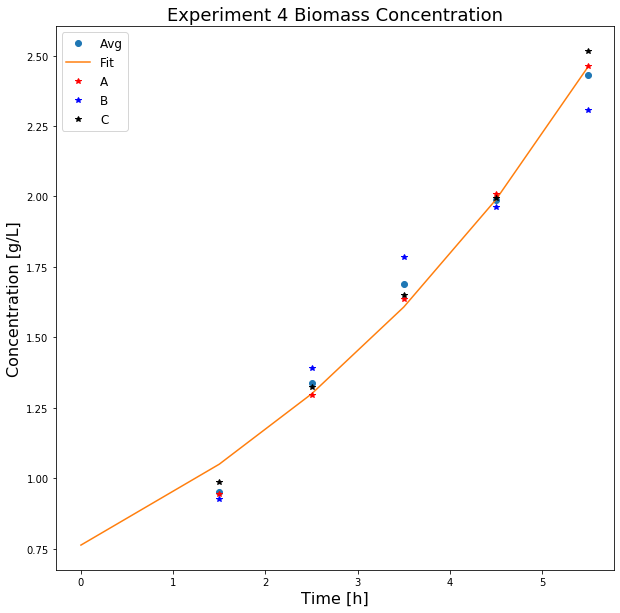

In [13]:
plt.figure(figsize=(10,10))

plt.title('Experiment 4 Biomass Concentration', fontsize = 18)

plt.xlabel('Time [h]', fontsize = 16)
plt.ylabel('Concentration [g/L]', fontsize = 16)

plt.plot(t1,Cx_4_avg,"o", label = "Avg")
plt.plot(t2_array,Cx_fit, label = "Fit")

plt.plot(t1, Cx_4_A,'*', color='red', label='A')
plt.plot(t1, Cx_4_B,'*', color='blue', label='B')
plt.plot(t1, Cx_4_C, '*', color='black', label='C')

plt.legend(loc='best', fontsize = 12)
plt.savefig('Mu_fit_E4.jpeg',dpi=1000)


In [14]:
Cx_fit[0]

0.7630684684660549

In [15]:
mu = mu_fit
mu

0.21288858190437157

# Fitting Gamma

In [16]:
t3_array = numpy.array([1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25])

In [17]:
T = 22 + 273.15
P = 101.325 #kPa

In [18]:
t_0 = 1.5
t_add1 = 3.0
t_add2 = 4.0
tmax=6

t_important = [0,t_0,t_add1, t_add2, tmax]
t_important

[0, 1.5, 3.0, 4.0, 6]

In [19]:
def response_fun(C):
    
    Cx, Ce, Cs = C[0],C[1], C[2]
    
    mu1=mu*Cs/(Km+Cs)
    theta1=theta
             
    S = numpy.matrix([[-1,1+alpha,1,0,0],
                      [ 0,0,-1,1,1.5],
                      [  0,beta,0,-1/3,0],
                      [ 0,-gamma,-1/3,0,1],
                      [ 0,1,0,0,0]])

    C = numpy.matrix([0, 0, 0, theta1, mu1]).T
    r = numpy.linalg.solve(S, C) 
        
    
    return [mu,        # biomass
            r[4,0],    # ethanol   
            r[0, 0]]    

In [20]:
def ferm_eq(t,C):
    Cx, Ce, Cs = C[0],C[1], C[2]   
    r=response_fun([Cx, Ce, Cs])
    
    return [r[0]*Cx,
            r[1]*Cx,
            r[2]*Cx]   

In [21]:
error = 1000
gamma_span = numpy.arange(0,2,0.001)

for gamma in gamma_span:
    
    squares = 0
    
    #Initial Concentrations at T=1.5
    Cx0 = Cx_fit[0]/24.6  #Initial Biomass Concentration g/L
    Ce0=0 #Non zero but low Ethanol Concentration
    Cg0=(25*2)/30 #Glucose as initially added
    Co=[Cx0, Ce0, Cg0]
    
    tspan = [0,6]

    C_sol=numpy.array([[],[],[]])
    t_sol=numpy.array([])
    
    for index,time in enumerate(t_important):

        if index==0:
            pass

        else:
            t_span=[t_important[index-1],time]
            teval=numpy.arange(t_important[index-1],time+0.5,0.5)
#             print (teval)

            C = scipy.integrate.solve_ivp(ferm_eq, t_span, Co, t_eval=teval)
#             print (C.y)

            C_sol=numpy.concatenate((C_sol,C.y),axis=1)

            Cx0 = C.y[0,-1]
            Ce0 = C.y[1,-1]
            Cg0 = C.y[2,-1]+((5*2)/30)
            Co=[Cx0, Ce0, Cg0]

            t_sol=numpy.concatenate((t_sol,teval))
            
            
            
    C_x_unique = numpy.array(uniquify(C_sol[0]))
    
#     Cx_u_2 = bio(t3_array,mu,Cx_fit[0])
    
    rco2_fit = []
    
    print (C_x_unique*24.6, gamma, Cx0)
    
    for index,value in enumerate(rco2_4_avg):
        
        rates = response_fun((C_sol[0][index], C_sol[1][index], C_sol[2][index]))

        rx, re, rs = rates

    
        fitted_rco2 = (0.5*re+alpha*rx)*(1/60)*8.314*(T+273)*1000/P*(C_x_unique[index]*24.6)/24.6*0.5

        squares+=(fitted_rco2-value)**2

        rco2_fit.append(fitted_rco2)
            
    if squares<error:
            
        gamma_acc=gamma
        error=squares
        rco2_fit_acc=rco2_fit

gamma_acc, mu

[0.76306847 0.84877326 0.94410402 1.05014197 1.16808991 1.29928484
 1.44521527 1.60753608 1.78808797 1.98891941 2.21230639 2.46078359
 2.73716886] 0.0 0.11126702679757129
[0.76306847 0.84877326 0.94410402 1.05014197 1.16808991 1.29928484
 1.44521527 1.60753608 1.78808797 1.98891941 2.21230639 2.46078359
 2.73716886] 0.001 0.11126702679324081
[0.76306847 0.84877326 0.94410402 1.05014197 1.16808991 1.29928484
 1.44521527 1.60753608 1.78808797 1.98891941 2.21230639 2.46078359
 2.73716886] 0.002 0.11126702678893999
[0.76306847 0.84877326 0.94410402 1.05014197 1.16808991 1.29928484
 1.44521527 1.60753608 1.78808797 1.98891941 2.21230639 2.46078359
 2.73716886] 0.003 0.11126702678466861
[0.76306847 0.84877326 0.94410402 1.05014197 1.16808991 1.29928484
 1.44521527 1.60753608 1.78808797 1.98891941 2.21230639 2.46078359
 2.73716886] 0.004 0.11126702678042619
[0.76306847 0.84877326 0.94410402 1.05014197 1.16808991 1.29928484
 1.44521527 1.60753608 1.78808797 1.98891941 2.21230639 2.46078359
 2.

[0.76306847 0.84877326 0.94410402 1.05014197 1.16808991 1.29928484
 1.44521526 1.60753608 1.78808796 1.98891941 2.21230638 2.46078359
 2.73716885] 0.062 0.11126702657660148
[0.76306847 0.84877326 0.94410402 1.05014197 1.16808991 1.29928484
 1.44521526 1.60753608 1.78808796 1.98891941 2.21230638 2.46078359
 2.73716885] 0.063 0.11126702657370366
[0.76306847 0.84877326 0.94410402 1.05014197 1.16808991 1.29928484
 1.44521526 1.60753608 1.78808796 1.98891941 2.21230638 2.46078359
 2.73716885] 0.064 0.11126702657082352
[0.76306847 0.84877326 0.94410402 1.05014197 1.16808991 1.29928484
 1.44521526 1.60753608 1.78808796 1.98891941 2.21230638 2.46078359
 2.73716885] 0.065 0.11126702656796097
[0.76306847 0.84877326 0.94410402 1.05014197 1.16808991 1.29928484
 1.44521526 1.60753608 1.78808796 1.98891941 2.21230638 2.46078359
 2.73716885] 0.066 0.11126702656511576
[0.76306847 0.84877326 0.94410403 1.05014197 1.16808991 1.29928484
 1.44521526 1.60753608 1.78808796 1.98891941 2.21230638 2.46078359
 

[0.76306847 0.84877325 0.94410403 1.05014197 1.16808991 1.29928484
 1.44521526 1.60753608 1.78808796 1.9889194  2.21230638 2.46078358
 2.73716885] 0.126 0.11126702642190019
[0.76306847 0.84877325 0.94410403 1.05014197 1.16808991 1.29928484
 1.44521526 1.60753608 1.78808796 1.9889194  2.21230638 2.46078358
 2.73716885] 0.127 0.1112670264199084
[0.76306847 0.84877325 0.94410403 1.05014197 1.16808991 1.29928484
 1.44521526 1.60753608 1.78808796 1.9889194  2.21230638 2.46078358
 2.73716885] 0.128 0.11126702641792774
[0.76306847 0.84877325 0.94410403 1.05014197 1.16808991 1.29928484
 1.44521526 1.60753608 1.78808796 1.9889194  2.21230638 2.46078358
 2.73716885] 0.129 0.11126702641595837
[0.76306847 0.84877325 0.94410403 1.05014197 1.16808991 1.29928484
 1.44521526 1.60753608 1.78808796 1.9889194  2.21230638 2.46078358
 2.73716885] 0.13 0.11126702641399973
[0.76306847 0.84877325 0.94410403 1.05014197 1.16808991 1.29928484
 1.44521526 1.60753608 1.78808796 1.9889194  2.21230638 2.46078358
 2.

 2.73716885] 0.189 0.11126702631561063
[0.76306847 0.84877325 0.94410403 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.9889194  2.21230638 2.46078358
 2.73716885] 0.19 0.1112670263141988
[0.76306847 0.84877325 0.94410403 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.9889194  2.21230638 2.46078358
 2.73716885] 0.191 0.11126702631279457
[0.76306847 0.84877325 0.94410403 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.9889194  2.21230638 2.46078358
 2.73716885] 0.192 0.11126702631139788
[0.76306847 0.84877325 0.94410403 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.9889194  2.21230638 2.46078358
 2.73716885] 0.193 0.11126702631000841
[0.76306847 0.84877325 0.94410403 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.9889194  2.21230638 2.46078358
 2.73716885] 0.194 0.11126702630862646
[0.76306847 0.84877325 0.94410403 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.788087

 2.73716885] 0.251 0.11126702624074974
[0.76306847 0.84877325 0.94410403 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.9889194  2.21230638 2.46078358
 2.73716885] 0.252 0.11126702623972992
[0.76306847 0.84877325 0.94410403 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.9889194  2.21230638 2.46078358
 2.73716885] 0.253 0.1112670262387156
[0.76306847 0.84877325 0.94410403 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.9889194  2.21230638 2.46078358
 2.73716885] 0.254 0.11126702623770622
[0.76306847 0.84877325 0.94410403 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.9889194  2.21230638 2.46078358
 2.73716885] 0.255 0.11126702623670218
[0.76306847 0.84877325 0.94410403 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.9889194  2.21230638 2.46078358
 2.73716885] 0.256 0.1112670262357034
[0.76306847 0.84877325 0.94410403 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.788087

 2.73716884] 0.307 0.11126702619104557
[0.76306847 0.84877325 0.94410403 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.9889194  2.21230637 2.46078358
 2.73716884] 0.308 0.11126702619028225
[0.76306847 0.84877325 0.94410403 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.9889194  2.21230637 2.46078358
 2.73716884] 0.309 0.11126702618952303
[0.76306847 0.84877325 0.94410403 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.9889194  2.21230637 2.46078358
 2.73716884] 0.31 0.11126702618876765
[0.76306847 0.84877325 0.94410403 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.9889194  2.21230637 2.46078358
 2.73716884] 0.311 0.11126702618801622
[0.76306847 0.84877325 0.94410403 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.9889194  2.21230637 2.46078358
 2.73716884] 0.312 0.11126702618726862
[0.76306847 0.84877325 0.94410403 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808

[0.76306847 0.84877325 0.94410403 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.9889194  2.21230637 2.46078358
 2.73716884] 0.363 0.11126702615387714
[0.76306847 0.84877325 0.94410403 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.9889194  2.21230637 2.46078358
 2.73716884] 0.364 0.11126702615330773
[0.76306847 0.84877325 0.94410403 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.9889194  2.21230637 2.46078358
 2.73716884] 0.365 0.11126702615274124
[0.76306847 0.84877325 0.94410403 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.9889194  2.21230637 2.46078358
 2.73716884] 0.366 0.11126702615217782
[0.76306847 0.84877325 0.94410403 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.9889194  2.21230637 2.46078358
 2.73716884] 0.367 0.11126702615161738
[0.76306847 0.84877325 0.94410403 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.9889194  2.21230637 2.46078358
 

 2.73716884] 0.418 0.11126702612668818
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.9889194  2.21230637 2.46078358
 2.73716884] 0.419 0.1112670261262656
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.9889194  2.21230637 2.46078358
 2.73716884] 0.42 0.11126702612584514
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.9889194  2.21230637 2.46078358
 2.73716884] 0.421 0.11126702612542723
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.9889194  2.21230637 2.46078358
 2.73716884] 0.422 0.11126702612501164
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.9889194  2.21230637 2.46078358
 2.73716884] 0.423 0.11126702612459838
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.788087

 2.73716884] 0.47600000000000003 0.1112670261057654
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.9889194  2.21230637 2.46078358
 2.73716884] 0.47700000000000004 0.11126702610546366
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.9889194  2.21230637 2.46078358
 2.73716884] 0.47800000000000004 0.11126702610516379
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.9889194  2.21230637 2.46078358
 2.73716884] 0.47900000000000004 0.11126702610486572
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.9889194  2.21230637 2.46078358
 2.73716884] 0.48 0.11126702610456952
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.9889194  2.21230637 2.46078358
 2.73716884] 0.481 0.11126702610427505
[0.76306847 0.84877324 0.94410404 1.050141

 2.73716884] 0.53 0.11126702609192353
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.531 0.11126702609171096
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.532 0.11126702609149997
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.533 0.11126702609129044
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.534 0.11126702609108238
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.535 0.11126702609087571
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808

 2.73716884] 0.59 0.11126702608160079
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.591 0.11126702608146745
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.592 0.11126702608133529
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.593 0.11126702608120438
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.594 0.11126702608107447
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.595 0.11126702608094594
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808

 2.73716884] 0.652 0.11126702607539744
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.653 0.11126702607532926
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.654 0.11126702607526198
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.655 0.11126702607519559
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.656 0.11126702607513018
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.657 0.11126702607506568
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.7880

 2.73716884] 0.71 0.11126702607288555
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.711 0.1112670260728663
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.712 0.11126702607284784
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.713 0.11126702607283016
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.714 0.11126702607281318
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.715 0.11126702607279698
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.788087

 2.73716884] 0.768 0.11126702607294993
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.769 0.11126702607297059
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.77 0.11126702607299215
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.771 0.11126702607301425
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.772 0.11126702607303687
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.773 0.11126702607306015
[0.76306847 0.84877324 0.94410404 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808

 2.73716884] 0.8310000000000001 0.11126702607539853
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.8320000000000001 0.11126702607545472
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.833 0.11126702607551152
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.834 0.11126702607556875
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.835 0.11126702607562651
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.836 0.11126702607568474
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.

 2.73716884] 0.881 0.1112670260787981
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.882 0.1112670260788777
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.883 0.11126702607895772
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.884 0.11126702607903807
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.885 0.11126702607911887
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.886 0.11126702607920025
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.788087

 2.73716884] 0.931 0.11126702608327559
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.932 0.11126702608337494
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.933 0.11126702608347472
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.934 0.11126702608357482
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.935 0.11126702608367531
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.936 0.11126702608377616
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.7880

 2.73716884] 0.983 0.11126702608890322
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.984 0.11126702608902005
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.985 0.11126702608913731
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.986 0.1112670260892549
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.987 0.11126702608937274
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 0.988 0.11126702608949082
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808

 2.73716884] 1.039 0.11126702609590017
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.04 0.11126702609603302
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.041 0.11126702609616601
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.042 0.11126702609629939
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753607 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.043 0.11126702609643294
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.044 0.11126702609656679
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808

 2.73716884] 1.099 0.11126702610429981
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.1 0.11126702610444679
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.101 0.1112670261045939
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.102 0.1112670261047414
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.103 0.11126702610488891
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.104 0.11126702610503683
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796

 2.73716884] 1.1520000000000001 0.11126702611236956
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.153 0.11126702611252706
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.154 0.11126702611268463
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.155 0.11126702611284241
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.156 0.11126702611300046
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.157 0.11126702611315861
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60

 2.73716884] 1.212 0.11126702612211813
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.213 0.1112670261222855
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.214 0.11126702612245301
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.215 0.11126702612262075
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.216 0.11126702612278853
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.217 0.11126702612295637
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808

 2.73716884] 1.266 0.11126702613135765
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.2670000000000001 0.11126702613153243
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.268 0.11126702613170743
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.2690000000000001 0.11126702613188236
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.27 0.11126702613205759
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.2710000000000001 0.11126702613223284
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.

 2.73716884] 1.318 0.11126702614060323
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.319 0.1112670261407841
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.32 0.11126702614096491
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.321 0.1112670261411459
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.322 0.111267026141327
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.323 0.1112670261415082
[0.76306847 0.84877324 0.94410405 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1

 2.73716884] 1.374 0.11126702615087929
[0.76306847 0.84877324 0.94410406 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.375 0.1112670261510655
[0.76306847 0.84877324 0.94410406 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.3760000000000001 0.1112670261512517
[0.76306847 0.84877324 0.94410406 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.377 0.11126702615143806
[0.76306847 0.84877324 0.94410406 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.3780000000000001 0.11126702615162443
[0.76306847 0.84877324 0.94410406 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.379 0.11126702615181092
[0.76306847 0.84877324 0.94410406 1.05014197 1.1680899  1.29928484
 1.44

 2.73716884] 1.427 0.11126702616085851
[0.76306847 0.84877324 0.94410406 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.428 0.11126702616104883
[0.76306847 0.84877324 0.94410406 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.429 0.1112670261612392
[0.76306847 0.84877324 0.94410406 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.43 0.11126702616142974
[0.76306847 0.84877324 0.94410406 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.431 0.11126702616162029
[0.76306847 0.84877324 0.94410406 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.432 0.11126702616181096
[0.76306847 0.84877324 0.94410406 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.788087

 2.73716884] 1.476 0.11126702621787132
[0.76306847 0.84877324 0.94410406 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716884] 1.477 0.11126702621941892
[0.76306847 0.84877324 0.94410406 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716885] 1.478 0.11126702622096925
[0.76306847 0.84877324 0.94410406 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716885] 1.479 0.11126702622252214
[0.76306847 0.84877324 0.94410406 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716885] 1.48 0.11126702622407778
[0.76306847 0.84877324 0.94410406 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.98891939 2.21230637 2.46078358
 2.73716885] 1.481 0.11126702622563595
[0.76306847 0.84877324 0.94410406 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808

 2.73716885] 1.526 0.11126702629837674
[0.76306847 0.84877324 0.94410406 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.9889194  2.21230637 2.46078358
 2.73716885] 1.5270000000000001 0.11126702630004891
[0.76306847 0.84877324 0.94410406 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.9889194  2.21230637 2.46078358
 2.73716885] 1.528 0.11126702630172308
[0.76306847 0.84877324 0.94410406 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.9889194  2.21230637 2.46078358
 2.73716885] 1.5290000000000001 0.1112670263033997
[0.76306847 0.84877324 0.94410406 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.9889194  2.21230637 2.46078358
 2.73716885] 1.53 0.1112670263050786
[0.76306847 0.84877324 0.94410406 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.9889194  2.21230637 2.46078358
 2.73716885] 1.5310000000000001 0.11126702630675972
[0.76306847 0.84877324 0.94410406 1.05014197 1.1680899  1.29

 2.73716885] 1.595 0.11126702641880436
[0.76306847 0.84877324 0.94410407 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.9889194  2.21230637 2.46078358
 2.73716885] 1.596 0.11126702642062015
[0.76306847 0.84877324 0.94410407 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.9889194  2.21230637 2.46078358
 2.73716885] 1.597 0.11126702642243778
[0.76306847 0.84877324 0.94410407 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.9889194  2.21230637 2.46078358
 2.73716885] 1.598 0.1112670264242572
[0.76306847 0.84877324 0.94410407 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.9889194  2.21230637 2.46078358
 2.73716885] 1.599 0.11126702642607861
[0.76306847 0.84877324 0.94410407 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.78808796 1.9889194  2.21230637 2.46078358
 2.73716885] 1.6 0.11126702642790177
[0.76306847 0.84877324 0.94410407 1.05014197 1.1680899  1.29928484
 1.44521526 1.60753608 1.7880879

 2.73716885] 1.649 0.11126702651939549
[0.76306847 0.84877324 0.94410407 1.05014197 1.1680899  1.29928484
 1.44521527 1.60753608 1.78808797 1.9889194  2.21230638 2.46078359
 2.73716885] 1.6500000000000001 0.11126702652130449
[0.76306847 0.84877324 0.94410407 1.05014197 1.1680899  1.29928484
 1.44521527 1.60753608 1.78808797 1.9889194  2.21230638 2.46078359
 2.73716885] 1.651 0.11126702652321514
[0.76306847 0.84877324 0.94410407 1.05014197 1.1680899  1.29928484
 1.44521527 1.60753608 1.78808797 1.9889194  2.21230638 2.46078359
 2.73716885] 1.6520000000000001 0.11126702652512734
[0.76306847 0.84877324 0.94410407 1.05014197 1.1680899  1.29928484
 1.44521527 1.60753608 1.78808797 1.9889194  2.21230638 2.46078359
 2.73716885] 1.653 0.11126702652704099
[0.76306847 0.84877324 0.94410407 1.05014197 1.1680899  1.29928484
 1.44521527 1.60753608 1.78808797 1.9889194  2.21230638 2.46078359
 2.73716885] 1.6540000000000001 0.11126702652895629
[0.76306847 0.84877324 0.94410407 1.05014197 1.1680899  1

 2.73716886] 1.705 0.11126702662860735
[0.76306847 0.84877324 0.94410407 1.05014197 1.1680899  1.29928484
 1.44521527 1.60753608 1.78808797 1.9889194  2.21230638 2.46078359
 2.73716886] 1.706 0.11126702663059787
[0.76306847 0.84877324 0.94410407 1.05014197 1.1680899  1.29928484
 1.44521527 1.60753608 1.78808797 1.9889194  2.21230638 2.46078359
 2.73716886] 1.707 0.11126702663258962
[0.76306847 0.84877324 0.94410407 1.05014198 1.1680899  1.29928484
 1.44521527 1.60753608 1.78808797 1.9889194  2.21230638 2.46078359
 2.73716886] 1.708 0.11126702663458274
[0.76306847 0.84877324 0.94410407 1.05014198 1.1680899  1.29928484
 1.44521527 1.60753608 1.78808797 1.9889194  2.21230638 2.46078359
 2.73716886] 1.709 0.11126702663657724
[0.76306847 0.84877324 0.94410407 1.05014198 1.1680899  1.29928484
 1.44521527 1.60753608 1.78808797 1.9889194  2.21230638 2.46078359
 2.73716886] 1.71 0.11126702663857305
[0.76306847 0.84877324 0.94410407 1.05014198 1.1680899  1.29928484
 1.44521527 1.60753608 1.78808

[0.76306847 0.84877324 0.94410408 1.05014198 1.1680899  1.29928484
 1.44521527 1.60753609 1.78808797 1.9889194  2.21230638 2.46078359
 2.73716886] 1.766 0.11126702675230679
[0.76306847 0.84877324 0.94410408 1.05014198 1.1680899  1.29928484
 1.44521527 1.60753609 1.78808797 1.9889194  2.21230638 2.46078359
 2.73716886] 1.7670000000000001 0.11126702675437074
[0.76306847 0.84877324 0.94410408 1.05014198 1.1680899  1.29928484
 1.44521527 1.60753609 1.78808797 1.9889194  2.21230638 2.46078359
 2.73716886] 1.768 0.11126702675643585
[0.76306847 0.84877324 0.94410408 1.05014198 1.1680899  1.29928484
 1.44521527 1.60753609 1.78808797 1.9889194  2.21230638 2.46078359
 2.73716886] 1.7690000000000001 0.111267026758502
[0.76306847 0.84877324 0.94410408 1.05014198 1.1680899  1.29928484
 1.44521527 1.60753609 1.78808797 1.9889194  2.21230638 2.46078359
 2.73716886] 1.77 0.11126702676056927
[0.76306847 0.84877324 0.94410408 1.05014198 1.1680899  1.29928484
 1.44521527 1.60753609 1.78808797 1.9889194  

 2.73716886] 1.825 0.1112670268758223
[0.76306847 0.84877324 0.94410408 1.05014198 1.1680899  1.29928484
 1.44521527 1.60753609 1.78808797 1.98891941 2.21230638 2.46078359
 2.73716886] 1.826 0.11126702687794439
[0.76306847 0.84877324 0.94410408 1.05014198 1.1680899  1.29928484
 1.44521527 1.60753609 1.78808797 1.98891941 2.21230638 2.46078359
 2.73716886] 1.827 0.11126702688006715
[0.76306847 0.84877324 0.94410408 1.05014198 1.1680899  1.29928484
 1.44521527 1.60753609 1.78808797 1.98891941 2.21230638 2.46078359
 2.73716886] 1.828 0.11126702688219094
[0.76306847 0.84877324 0.94410408 1.05014198 1.1680899  1.29928484
 1.44521527 1.60753609 1.78808797 1.98891941 2.21230638 2.46078359
 2.73716886] 1.829 0.11126702688431546
[0.76306847 0.84877324 0.94410408 1.05014198 1.1680899  1.29928484
 1.44521527 1.60753609 1.78808797 1.98891941 2.21230638 2.46078359
 2.73716886] 1.83 0.11126702688644101
[0.76306847 0.84877324 0.94410408 1.05014198 1.1680899  1.29928484
 1.44521527 1.60753609 1.788087

 2.73716886] 1.8840000000000001 0.11126702700242812
[0.76306847 0.84877324 0.94410408 1.05014198 1.1680899  1.29928485
 1.44521527 1.60753609 1.78808797 1.98891941 2.21230639 2.4607836
 2.73716886] 1.885 0.11126702700459691
[0.76306847 0.84877324 0.94410408 1.05014198 1.1680899  1.29928485
 1.44521527 1.60753609 1.78808797 1.98891941 2.21230639 2.4607836
 2.73716886] 1.8860000000000001 0.11126702700676647
[0.76306847 0.84877324 0.94410408 1.05014198 1.1680899  1.29928485
 1.44521527 1.60753609 1.78808797 1.98891941 2.21230639 2.4607836
 2.73716886] 1.887 0.11126702700893673
[0.76306847 0.84877324 0.94410408 1.05014198 1.1680899  1.29928485
 1.44521527 1.60753609 1.78808797 1.98891941 2.21230639 2.4607836
 2.73716886] 1.8880000000000001 0.11126702701110765
[0.76306847 0.84877324 0.94410408 1.05014198 1.1680899  1.29928485
 1.44521527 1.60753609 1.78808797 1.98891941 2.21230639 2.4607836
 2.73716886] 1.889 0.11126702701327917
[0.76306847 0.84877324 0.94410408 1.05014198 1.1680899  1.2992

 2.73716887] 1.946 0.11126702713812757
[0.76306847 0.84877324 0.94410409 1.05014198 1.16808991 1.29928485
 1.44521527 1.60753609 1.78808798 1.98891941 2.21230639 2.4607836
 2.73716887] 1.947 0.11126702714033511
[0.76306847 0.84877324 0.94410409 1.05014198 1.16808991 1.29928485
 1.44521527 1.60753609 1.78808798 1.98891941 2.21230639 2.4607836
 2.73716887] 1.948 0.11126702714254327
[0.76306847 0.84877324 0.94410409 1.05014198 1.16808991 1.29928485
 1.44521527 1.60753609 1.78808798 1.98891941 2.21230639 2.4607836
 2.73716887] 1.949 0.1112670271447519
[0.76306847 0.84877324 0.94410409 1.05014198 1.16808991 1.29928485
 1.44521527 1.60753609 1.78808798 1.98891941 2.21230639 2.4607836
 2.73716887] 1.95 0.1112670271469611
[0.76306847 0.84877324 0.94410409 1.05014198 1.16808991 1.29928485
 1.44521527 1.60753609 1.78808798 1.98891941 2.21230639 2.4607836
 2.73716887] 1.951 0.11126702714917078
[0.76306847 0.84877324 0.94410409 1.05014198 1.16808991 1.29928485
 1.44521527 1.60753609 1.78808798 1.9

 2.73716887] 1.998 0.1112670272535914
[0.76306847 0.84877324 0.94410409 1.05014198 1.16808991 1.29928485
 1.44521528 1.60753609 1.78808798 1.98891941 2.21230639 2.4607836
 2.73716887] 1.999 0.11126702725582419


(1.052, 0.21288858190437157)

In [22]:
gamma_acc, mu, error

(1.052, 0.21288858190437157, 6.762606571368565)

In [23]:
rco2_fit = rco2_fit_acc
rco2_fit

[3.814392299146894,
 4.242809669157828,
 4.71934533688154,
 5.249403301787954,
 5.839000407669438,
 6.494812662470315,
 7.224284158644776,
 8.03568739844023,
 8.938227279322897]

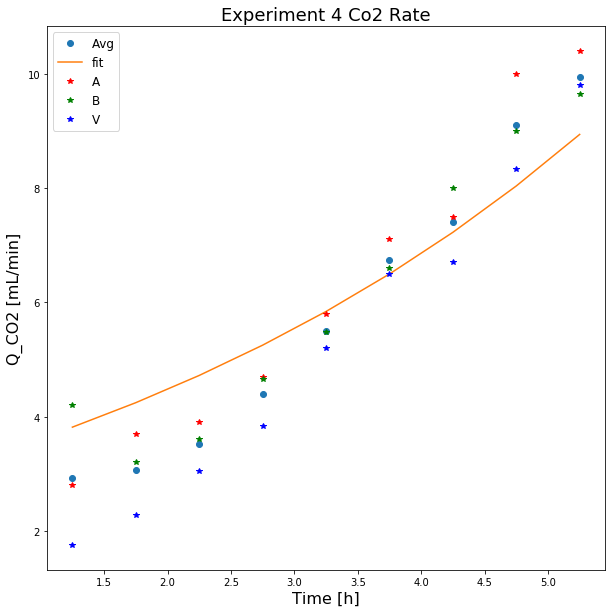

In [24]:
plt.figure(figsize=(10,10))

plt.title('Experiment 4 Co2 Rate', fontsize = 18)

plt.xlabel('Time [h]', fontsize = 16)
plt.ylabel('Q_CO2 [mL/min]', fontsize = 16)

plt.plot(t2,rco2_4_avg,"o", label='Avg')

plt.plot(t3_array,rco2_fit, label='fit')

plt.plot(t2,rco2_4_A,"*r", label='A')
plt.plot(t2,rco2_4_B,"*g", label='B')
plt.plot(t2,rco2_4_C,"*b", label='V')

plt.legend(loc='best', fontsize = 12)

plt.savefig('Rco2_E4.jpeg',dpi=1000)

# Plot Theory To Data

In [25]:
gamma = gamma_acc
# gamma = 1.45
mu, gamma

(0.21288858190437157, 1.052)

In [26]:
#Initial Concentrations at T=1.5

Cx0 = Cx_fit[0]/24.6  #Initial Biomass Concentration g/L
print (Cx0, "g/L")

Ce0=0.1 #Non zero but low Ethanol Concentration

Cg0=(25*2)/30 #Glucose as initially added

Co=[Cx0, Ce0, Cg0]

0.031019043433579467 g/L


In [27]:
t_0 = 1.5
t_add1 = 3.0
t_add2 = 4.0
tmax=6

t_important = [0,t_0,t_add1, t_add2, tmax]
t_important

[0, 1.5, 3.0, 4.0, 6]

In [28]:
C_sol=numpy.array([[],[],[]])
t_sol=numpy.array([])

for index,time in enumerate(t_important):
#     print (index,time)    
    
    if index==0:
        pass
    
    else:
        t_span=[t_important[index-1],time]
#         print (t_span)
        teval=numpy.arange(t_important[index-1],time+0.5,0.5)
        print (teval)
        C = scipy.integrate.solve_ivp(ferm_eq, t_span, Co, t_eval=teval)
#         print (C_sol,C.y)
        print (C.y)
        C_sol=numpy.concatenate((C_sol,C.y),axis=1)
        
#         print (Co, "Co pre")
        Cx0 = C.y[0,-1]
        Ce0 = C.y[1,-1]
        Cg0 = C.y[2,-1]+((5*2)/30)
        Co=[Cx0, Ce0, Cg0]
        t_sol=numpy.concatenate((t_sol,teval))
#         print (Co, "Co post")
    
print(C_sol, t_sol)

#There is a duplication of times, which is intentional to allow for plotting of the discontinous glucose concentrations

[0.  0.5 1.  1.5]
[[0.03101904 0.03450299 0.03837822 0.0426887 ]
 [0.1        0.10966347 0.12041226 0.13236831]
 [1.66666667 1.68603937 1.70758784 1.73155656]]
[1.5 2.  2.5 3. ]
[[0.0426887  0.04748334 0.05281647 0.0587486 ]
 [0.13236831 0.14566729 0.16045988 0.17691394]
 [2.0648899  2.09155082 2.12120606 2.15419208]]
[3.  3.5 4. ]
[[0.0587486  0.065347   0.07268651]
 [0.17691394 0.19521607 0.21557382]
 [2.48752541 2.52421635 2.56502824]]
[4.  4.5 5.  5.5 6. ]
[[0.07268651 0.0808504  0.08993118 0.10003187 0.11126705]
 [0.21557382 0.23821817 0.26340571 0.29142222 0.32258548]
 [2.89836157 2.9437575  2.99425186 3.05041755 3.11289163]]
[[0.03101904 0.03450299 0.03837822 0.0426887  0.0426887  0.04748334
  0.05281647 0.0587486  0.0587486  0.065347   0.07268651 0.07268651
  0.0808504  0.08993118 0.10003187 0.11126705]
 [0.1        0.10966347 0.12041226 0.13236831 0.13236831 0.14566729
  0.16045988 0.17691394 0.17691394 0.19521607 0.21557382 0.21557382
  0.23821817 0.26340571 0.29142222 0.3225

In [29]:
Cx=C_sol[0]*24.6             
print (Cx)
Ce=C_sol[1]*23

Cx_u = uniquify(numpy.array(Cx))
Cx_u

[0.76306847 0.84877352 0.94410417 1.05014206 1.05014206 1.16809017
 1.29928511 1.44521546 1.44521546 1.60753629 1.78808821 1.78808821
 1.98891987 2.21230692 2.46078399 2.73716934]


[0.7630684684660549,
 0.8487735192185158,
 0.9441041662350234,
 1.0501420613266592,
 1.1680901660946297,
 1.2992851052489256,
 1.4452154620799542,
 1.6075362948729057,
 1.788088207246312,
 1.9889198671628459,
 2.212306923678847,
 2.46078399461451,
 2.7371693386910483]

In [30]:
# Cx_plot = numpy.concatenate((numpy.array([Cx_fit[0]]),Cx))
# t_sol_plot = numpy.concatenate((numpy.array([0]),t_sol))

In [31]:
Cx, t_sol

(array([0.76306847, 0.84877352, 0.94410417, 1.05014206, 1.05014206,
        1.16809017, 1.29928511, 1.44521546, 1.44521546, 1.60753629,
        1.78808821, 1.78808821, 1.98891987, 2.21230692, 2.46078399,
        2.73716934]),
 array([0. , 0.5, 1. , 1.5, 1.5, 2. , 2.5, 3. , 3. , 3.5, 4. , 4. , 4.5,
        5. , 5.5, 6. ]))

In [32]:
# Cx_plot, t_sol_plot

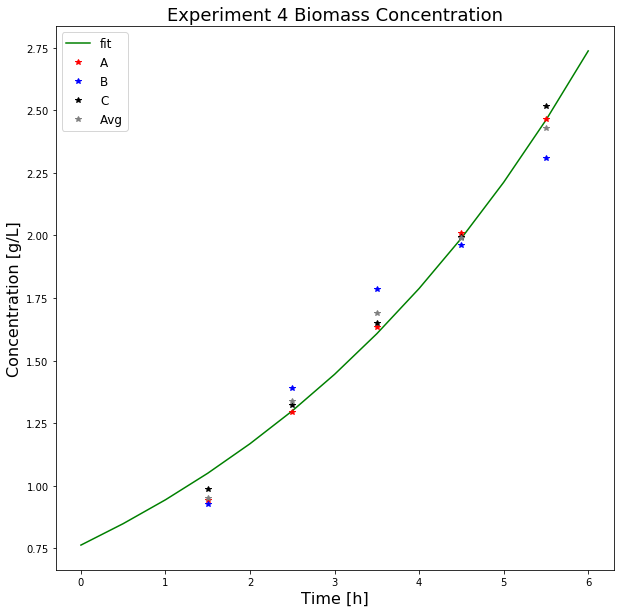

In [33]:
plt.figure(figsize=(10,10))

plt.title('Experiment 4 Biomass Concentration', fontsize = 18)

plt.xlabel('Time [h]', fontsize = 16)
plt.ylabel('Concentration [g/L]', fontsize = 16)

plt.plot(t_sol, Cx, "-",color='green',label='fit')
plt.plot(t1, Cx_4_A,'*', color='red', label='A')
plt.plot(t1, Cx_4_B,'*', color='blue', label='B')
plt.plot(t1, Cx_4_C, '*', color='black', label='C')
plt.plot(t1, Cx_4_avg, '*', color='grey', label='Avg')

plt.legend(loc='best', fontsize = 12)

plt.savefig('Cx_E4.jpeg',dpi=1000)

plt.show()



In [34]:
mu, gamma

(0.21288858190437157, 1.052)

In [35]:
γ

NameError: name 'γ' is not defined